# Spatial methods

## Part 1: Effect of schools on house prices

[Check the 'issues' thread](https://github.com/abjer/tsds/issues)

In this exercise we are gonna reproduce the methodology from **Do Better Schools Matter? Parental Evaluation of Elementary Education** (Sandra E. Black, 1999), where residential sales along the borders between school districts are used to estimate the effect of how well the local school performs on square meter prices. The basic assumption is that residences in different school districts right next to the district border are only systematically different with regard to the assigned school district. See *Black 1999* for details. 

We will roughly follow the project of Asger Andersen from the Social Data Science summer school course: https://github.com/AsgerAndersen/schooldistrictshouseprices

**Import libraries**

In [27]:
import shapely as shp
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

## The data
#### Load data

The school districts of Copenhagen in school year 17/18. We also have school districts from earlier years, see the data folder (Absalon). The data is downloaded from the Copnhagen municipality's data platform: https://data.kk.dk

In [6]:
districts = gpd.read_file('./data/school_districts_2017_2018.geojson')

Socioeconomic measures registered by the Copenhagen municipality from 2008 to 2016. Not all measures are recorded all years. The units are so-called *roder*, which are small areas that used to be used for managing tax collection. Most of measures are in percent of the people living in the given *rode*. All these measures are rounded to the nearest 5. That 20 percent of the *rode* residents have low income should therefore means that 17.5-22.5 percent of the *rode* residents have low income. The data is downloaded from the Copnhagen municipality's open platform: https://data.kk.dk

In [7]:
socioeco = gpd.read_file('./data/socioeco_edited.geojson')

Yearly grade averages of Copenhagen primary schools from 2012 to 2017. The data is downloaded from the Ministry of Education's data platform: https://uddannelsesstatistik.dk

In [8]:
school_perf = pd.read_csv('./data/school_perf.csv')

Residential sales in the Copenhagen municipality from 2014 to 2018. The data is scraped from boligsiden: https://www.boligsiden.dk

In [9]:
house_sales = gpd.read_file('./data/sales.geojson')

The coordinates of the boundary of the Copenhagen municipality:

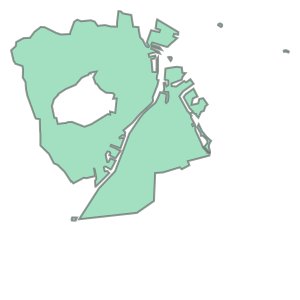

In [10]:
cph_map = gpd.read_file('./data/cph_map.geojson').iloc[0,0]
cph_map

#### Preprocess data

In [11]:
districts = districts[['skoleid','skolenavn','geometry']]

We want to use the square meter price of the house sales in year 2017 and 2018 as our response variable:

In [12]:
house_sales = house_sales[house_sales['year']>2016]

The square meter price of the house sales has a heavy right tail with extra ordinary high prices, and also a quite heavy left tail with unusually low prices. Whatever it is that makes these sales have such unsual square meter prices, it is reasonable assume that it is not their local school district. We therefore remove the sales above the 99th percentile of square meter prices and below the 1rst percentile to make sure their influence does not dominate the analysis.

In [13]:
percs = house_sales['price_m2'].quantile([0.01,0.99])
percs

0.01    13.719477
0.99    68.968472
Name: price_m2, dtype: float64

Text(0.5, 0.98, 'Distribution of square meter prices')

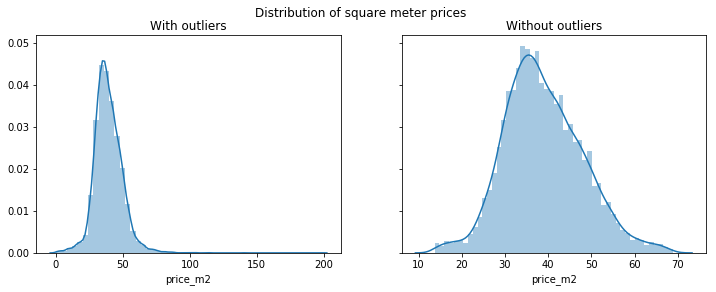

In [14]:
sales_dist_plt = plt.subplots(1,2,sharey=True,figsize=(12,4))
sns.distplot(house_sales['price_m2'], ax=sales_dist_plt[1][0]) 
house_sales = house_sales[(percs[0.01]<house_sales['price_m2']) & (house_sales['price_m2']<percs[0.99])]
sns.distplot(house_sales['price_m2'], ax=sales_dist_plt[1][1])
sales_dist_plt[1][0].set_title('With outliers')
sales_dist_plt[1][1].set_title('Without outliers')
sales_dist_plt[0].suptitle('Distribution of square meter prices')

We use schools' average grade average from 2012 to 2016 as our treatment variable:

In [15]:
districts_perf = districts.merge(school_perf[school_perf['year']<2017].drop('year',axis=1).groupby('skolenavn',as_index=False).mean())

We use the average of the socioeconomic measures from 2013 to 2016 as our variables describing neighbourhood characteristics.

In [16]:
socioeco_sub = socioeco\
    .loc[socioeco['aar']==2016,['rode_nr','geometry']]\
    .merge(socioeco[socioeco['aar']>2012]\
               .groupby('rode_nr',as_index=False)\
               .mean()
          )\
    .drop('aar',axis=1)

#### Visualize data

Plot of school districts and residential sales. The plot on the right is colored by the schools' average grade average from 2012 to 2016 (note that some newer districts have no grades data):


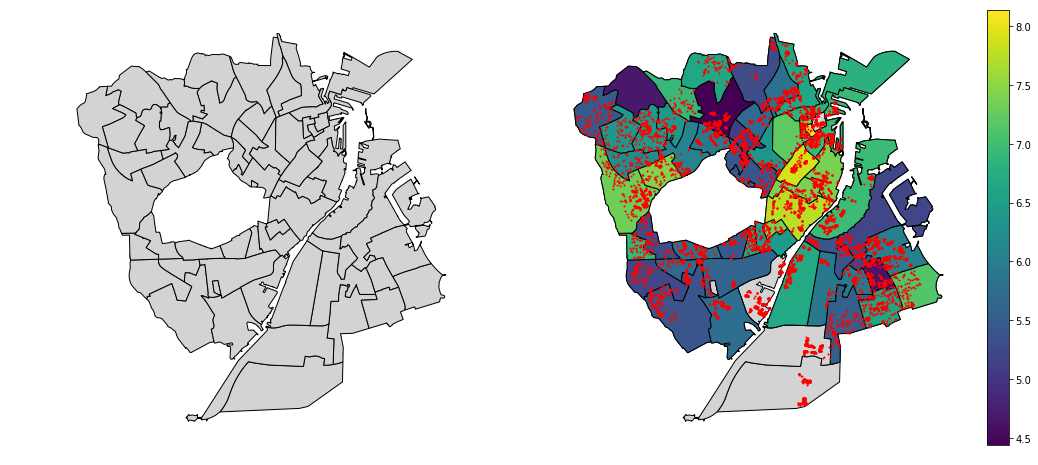

In [24]:
districts_perf_plt = plt.subplots(1,2,figsize=(18,8), gridspec_kw = {'width_ratios':[1,1.25]})
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][0])
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][1])
districts_perf.plot(edgecolor='black',column='karsnit',legend=True,ax=districts_perf_plt[1][1])
house_sales.plot(color='red', markersize=1,ax=districts_perf_plt[1][1])
districts_perf_plt[1][0].set_axis_off()
districts_perf_plt[1][1].set_axis_off()

> **Ex 10.1.1**: *Border regions between school districts*.
> Make a function that finds the borders between the school districts given some specified border-width W. Make sure that your border building function satisfy the following constraints:
 - The borders should not intersect each other. There should be no borders between the school districts without any grade data and any other school districts. 
 - Do not include borders between two school districts, if the district border coincides with a natural geographical border, such that the neighborhoods on each side of the geographical border are likely to be systematically different with regard to other variables than the school characteristics. For instance, it would be natural to exclude the Christianhavn school district from the analysis, since it is surrounded by the harbor and *Voldene*, and likewise it would be natural not to include the border between two school districts, if they are on different sides of the harbor. 

> Compute the borders for the following border meter widths: 50, 100, 200, 300, 500. A border width of, for instance, 50 meters means that the computed border area should reach 25 meter into each district along the actual border:

>> **Hint**: One approach is to use a combination of the *buffer* and *overlay* function from *Geopandas* to construct the borders. Depending on your choice of method, the found borders will likely overlap, but you can then use *overlay* to find the overlap. After you have found the overlaps, you can use the *shapely* function *difference* to remove them. You can use a similar approach with the *cph_map* from above to remove borders between school districts on different sides of the harbor.

>> **Hint 2**: The borders produced should look like this.

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/border_plt.png">


In [28]:
# [Answer to ex. 10.1.1 here]

schools = school_perf['skolenavn'].unique() # School districts with no grade data
no_perf_area = districts[~(districts['skolenavn'].isin(schools))]['geometry'].unary_union

def make_borders(districts, border_width) :
    
    ################
    # make borders #
    ################
    
    # put buffer 
    buffer_dist = border_width / 2
    districts['geometry'] = districts.buffer(buffer_dist)
    
    # make overlay
    borders = gpd.overlay(districts,districts,how='intersection')
    borders = borders[~(borders['geometry'].apply(lambda poly : poly.is_empty))]
    borders = borders[borders['skoleid_1']!=borders['skoleid_2']]
    
    # name borders
    borders['border_id'] = borders.apply(lambda row : sorted((row['skoleid_1'],row['skoleid_2'])),axis=1)
    borders['border_id'] = borders['border_id'].apply(lambda border : '{0}-{1}'.format(border[0],border[1]))
    borders = borders.drop_duplicates('border_id').reset_index(drop=True)
    
    #####################
    # remove irrelevant #
    #####################
    
    # conflicting border 
    conflict_b = gpd.overlay(borders[['border_id','geometry']],
                             borders[['border_id','geometry']],
                             how='intersection')
    non_empty = pd.Series(~(conflict_b['geometry'].apply(lambda poly : poly.is_empty)))
    has_conflict = conflict_b['border_id_1']!=conflict_b['border_id_2']      
    conflict_b_uu = conflict_b[non_empty & has_conflict].geometry.unary_union
        
    # join with water 
    removal = shp.geometry.box(*cph_map.bounds).difference(cph_map).buffer(buffer_dist)    
    removal = removal.union(conflict_b_uu).union(no_perf_area.buffer(buffer_dist))
    
    # apply removal 
    borders['geometry'] = borders['geometry'].apply(lambda border : border.difference(removal))
    borders = borders[~(borders['geometry'].apply(lambda poly : poly.is_empty))]
    
    return borders.reset_index(drop=True)

In [29]:
# apply border function
border_widths = [50,100,150,200,300,500]
remove_chr_havn = districts_perf['skolenavn']!='Christianshavns Skole'
# removal, conflict_b_uu, no_perf_area, buffer_dist = make_borders(districts_perf[remove_chr_havn].copy(),50)
borders = [make_borders(districts_perf[remove_chr_havn].copy(),d) for d in border_widths]

In [42]:
borders[5].head(2)

,skoleid_1,skolenavn_1,karsnit_1,skoleid_2,skolenavn_2,karsnit_2,geometry,border_id
0,101020,Kirkebjerg Skole,6.26,101021,Korsager Skole,5.48,"POLYGON ((718064.4284816019 6178351.524552162,...",101020-101021
1,101023,Tingbjerg Skole,4.68,101021,Korsager Skole,5.48,(POLYGON ((718033.6201053072 6179698.460216083...,101021-101023


<br>

**Ex 10.1.2**: Do the following
  1. Merge the residential sales with the school districts and socioeconomic data based on the coordinates of the sale and the school districts and rode areas (CPH municapality's spatial cells). 
  2. Find the residential sales located within the sets of borders for the different border widths. 
  3. Plot the located within the border sets for the different border widths.

> **Hint**: Recall the `sjoin` function from `geopandas` may be of help.

The selected houses within borders should look like:

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/border_sales_plt.png">


In [44]:
# [Answer to ex. 10.1.2 here]
# mergning data
house_sales_dp = gpd.sjoin(left_df=house_sales,
                          right_df=districts_perf, 
                          how='left',
                          op='within')\
                .drop('index_right', axis=1)
house_sales_char = gpd.sjoin(left_df=house_sales_dp,
                          right_df=socioeco_sub, 
                          how='left',
                          op='within')\
                .drop('index_right', axis=1)

# sales within borders
border_sales = [gpd.sjoin(left_df=house_sales_char,
                          right_df=bord[['border_id', 'geometry']], 
                          how='left',
                          op='within')\
                .drop('index_right', axis=1)
            for bord in borders]


# plot sales within borders
border_sales.plt = plt.subplot(1,2,figsize=(24,12))
districts.plot(color='lightgrey',ax=border_sales_plt[1][0])

<br>

**Ex 10.1.3**:  Run a linear regression of the effect of schools' grade average on square meter prices, where you control for the size of the sold property and relevant socioeconomic properties of the neighborhood. We have used percent of non-western immigrants and descendants, low income, non-educated and high school educated as our socioeconomic variables, but you can play around with it.

In [ ]:
# [Answer to ex. 10.1.3 here]

<br>

**Ex 10.1.4**:  For each border width now try to run a linear regression of the effect of schools' average grade on square meter prices, where you only use the sales within the borders and control for residential area, socioeconomic neighborhood properties and border fixed effects.

In [ ]:
# [Answer to ex. 10.1.4 here]

<br>

**Ex 10.1.5**:  Compare the estimated effect from the controlled linear regression on all sales with the estimated effects from the linear regressions on the different border sets. The figure below show a summary of the results, we get from our analysis. The blue lines are confidence intervals of the effect of schools' average grade on house prices estimated with the different border sets (we do not use clustering). The grey area shows the confidence interval from the controlled linear regression model on all the sales.

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/results_fig.png">

Would you say that the results suggest that there is a causal effect of the local shool's average grade on square meter price? Would you have expected that the estimated effect declines, when borders of greater width are used to estimate it? If not, what could explain that we this? Investigate your hypothesis, if you have time  for it (and tell us, if you find something interesting).


In [ ]:
# [Answer to ex. 10.1.5 here]

<br>

**Ex 10.1.6 (BONUS)**:
Think about how the methodology of (Black 1999) can be improved. For instance, this method "matches" sales along the same border, although they might be far away from each other, if the border stretches over a large area. Consider if we could come up with a method for matching sales on different sides of a border only if they are close to each other.

In [ ]:
# [Answer to ex. 10.1.6 here]